In [ ]:
%%capture
%pip install nnsight

In [ ]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import einops
from collections import defaultdict
from tqdm.notebook import tqdm_notebook
from nnsight import NNsight
import seaborn as sns

%precision 4
t.manual_seed(0)
t.cuda.manual_seed(0)
random.seed(0)

sns.set_theme("notebook")
sns.set_style("white")

t.set_default_dtype(t.float64)

# Config


In [ ]:
p = 113
d_model = 128
n_heads = 4
d_vocab = p+1
d_hidden = 4*d_model

assert d_model%n_heads == 0, "d_model must be divisible by d_head"

d_head = d_model//n_heads

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.W_Q = nn.Parameter(t.randn(n_heads, d_model, d_head))
        t.nn.init.xavier_uniform_(self.W_Q)
        self.W_K = nn.Parameter(t.randn(n_heads, d_model, d_head))
        t.nn.init.xavier_uniform_(self.W_K)
        self.W_V = nn.Parameter(t.randn(n_heads, d_model, d_head))
        t.nn.init.xavier_uniform_(self.W_V)
        self.W_O = nn.Parameter(t.randn(n_heads, d_head, d_model))
        t.nn.init.xavier_uniform_(self.W_O)

    def forward(self, x):
        q = einops.einsum(x, self.W_Q, "batch pos d_model, n_heads d_model d_head -> batch n_heads pos d_head")
        k = einops.einsum(x, self.W_K, "batch pos d_model, n_heads d_model d_head -> batch n_heads pos d_head")
        v = einops.einsum(x, self.W_V, "batch pos d_model, n_heads d_model d_head -> batch n_heads pos d_head")

        z = F.scaled_dot_product_attention(q, k, v)
        out = einops.einsum(z, self.W_O, "batch n_heads pos d_head, n_heads d_head d_model -> batch pos d_model")

        return out

class BilinearMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.W = nn.Linear(d_model, d_hidden, bias=False)
        t.nn.init.xavier_uniform_(self.W.weight)
        self.V = nn.Linear(d_model, d_hidden, bias=False)
        t.nn.init.xavier_uniform_(self.V.weight)
        self.P = nn.Linear(d_hidden, d_model, bias=False)
        t.nn.init.xavier_uniform_(self.P.weight)
    def forward(self, x):
        return self.P(self.W(x) * self.V(x))

class TransformerBilinearMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.pos_emb = nn.Parameter(t.randn(1, 3, d_model))
        t.nn.init.xavier_uniform_(self.pos_emb)
        self.emb = nn.Embedding(d_vocab, d_model)
        self.attn = MultiHeadAttention()
        self.bl_mlp = BilinearMLP()
        self.unemb = nn.Linear(d_model, p)

    def forward(self, x):
        x = self.emb(x) + self.pos_emb
        x = x + self.attn(x)
        x = x + self.bl_mlp(x)
        x = self.unemb(x)
        return x

# Train

### Generate train and test dataset

In [ ]:
X_y_pairs = [[m, n, p, (m+n)%p] for m in range(p) for n in range(p)]

random.shuffle(X_y_pairs)
split_pos = int(len(X_y_pairs)*0.8)

X_y_tensor = t.tensor(X_y_pairs, dtype=t.long, device="cuda")

trainset, testset = X_y_tensor[:split_pos], X_y_tensor[split_pos:]

X_train = trainset[:,:-1]
y_train = trainset[:,-1]

X_test = testset[:,:-1]
y_test = testset[:,-1]


## Run training

In [ ]:
t.set_grad_enabled(True)
model = TransformerBilinearMLP().to("cuda")
optim = t.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
record = defaultdict(list)
max_epochs=3000
for epoch in tqdm_notebook(range(max_epochs)):
    record["epoch"].append(epoch)
    optim.zero_grad()
    y_pred = model(X_train)[:, -1, :]
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optim.step()
    record["train_loss"].append(loss.item())
    record["train_accuracy"].append((y_pred.argmax(dim=-1)==y_train).float().mean().item())
    with t.no_grad():
        y_pred = model(X_test)[:, -1, :]
        loss = loss_fn(y_pred, y_test)
        record["test_loss"].append(loss.item())
        record["test_accuracy"].append((y_pred.argmax(dim=-1)==y_test).float().mean().item())
    if epoch % 1000 == 0 or epoch==max_epochs-1:
        display({k:v[-1] for k,v in record.items()})

  0%|          | 0/3000 [00:00<?, ?it/s]

{'epoch': 0,
 'train_loss': 4.9424,
 'train_accuracy': 0.0086,
 'test_loss': 4.8157,
 'test_accuracy': 0.0067}

{'epoch': 1000,
 'train_loss': 0.0020,
 'train_accuracy': 1.0000,
 'test_loss': 0.8680,
 'test_accuracy': 0.8528}

{'epoch': 2000,
 'train_loss': 0.0004,
 'train_accuracy': 1.0000,
 'test_loss': 0.0027,
 'test_accuracy': 0.9992}

{'epoch': 2999,
 'train_loss': 0.0002,
 'train_accuracy': 1.0000,
 'test_loss': 0.0004,
 'test_accuracy': 1.0000}

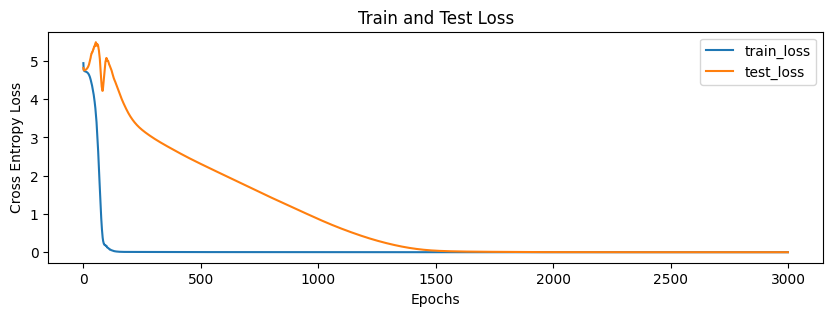

In [ ]:
plt.figure(figsize=(10,3))
plt.title("Train and Test Loss")
plt.plot(record["train_loss"], label="train_loss")
plt.plot(record["test_loss"], label="test_loss")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
t.save(model.state_dict(), "saved_model.pt")

# Analyze

In [ ]:
t.set_grad_enabled(False)
model = TransformerBilinearMLP().to("cuda")
model.load_state_dict(t.load("saved_model.pt"))

model=NNsight(model)

W_E = model.emb.weight
W_U = model.unemb.weight

In [ ]:
def bilinear_tensor(model):
    W: t.Tensor = model.bl_mlp.W.weight    # (H, D)
    V: t.Tensor = model.bl_mlp.V.weight    # (H, D)
    H, D = W.shape
    # Per-hidden interaction matrices: B_h = w_h ⊗ v_h  -> shape (H, D, D)
    B_h = t.einsum('hi,hj->hij', W, V)
    P: t.Tensor = model.bl_mlp.P.weight  # (O, H)
    # Combine hidden slices with P: B_a = sum_h P[a,h] * B_h
    B = t.einsum('ah,hij->aij', P, B_h)  # (O, D, D)
    B = 0.5 * (B + B.transpose(-1, -2))
    return B

def hosvd_B(B):
    # Compute full bilinear tensor
    O, D, _ = B.shape
    # Flatten the two input dims -> (O, D*D)
    B_flat = B.reshape(O, D * D)
    # Standard SVD
    U, S, Vh = t.linalg.svd(B_flat, full_matrices=False)     # (O, r), (r,), (r, D*D)
    # Reshape right singular vectors into matrices
    Q = Vh.reshape(-1, D, D)                                    # (r, D, D)
    return U, S, Q

In [ ]:
B = bilinear_tensor(model)
U,S,Q = hosvd_B(B)

Text(0.5, 0, '$i$')

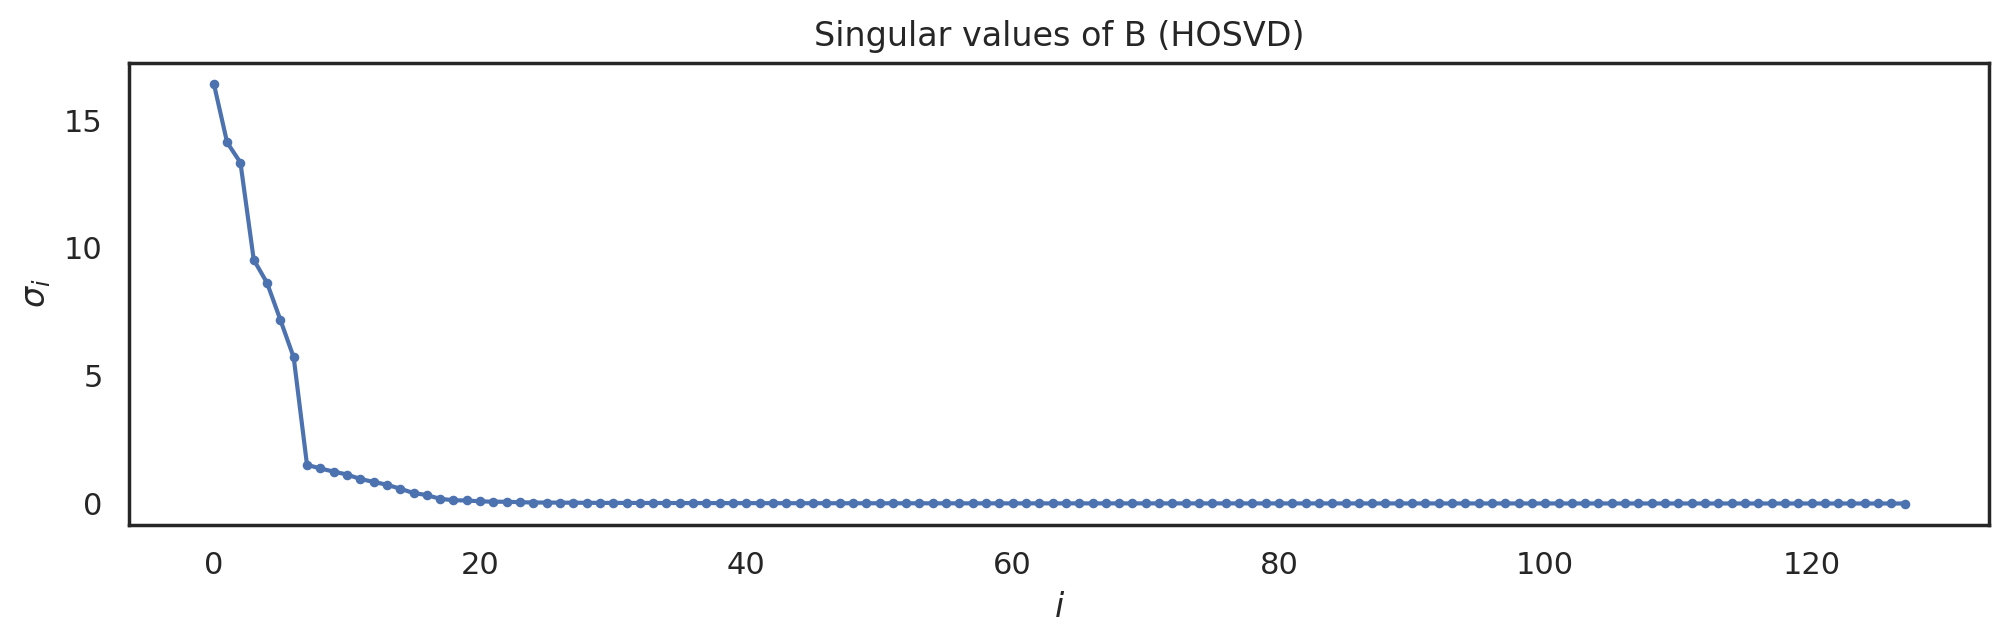

In [ ]:
cm = plt.get_cmap('viridis')
plt.figure(figsize=(12,3), dpi=200)
plt.plot(S.cpu())
plt.title("Singular values of B (HOSVD)")
plt.scatter(range(d_model), S.cpu(), s=6)
plt.ylabel("$\\sigma_i$")
plt.xlabel("$i$")

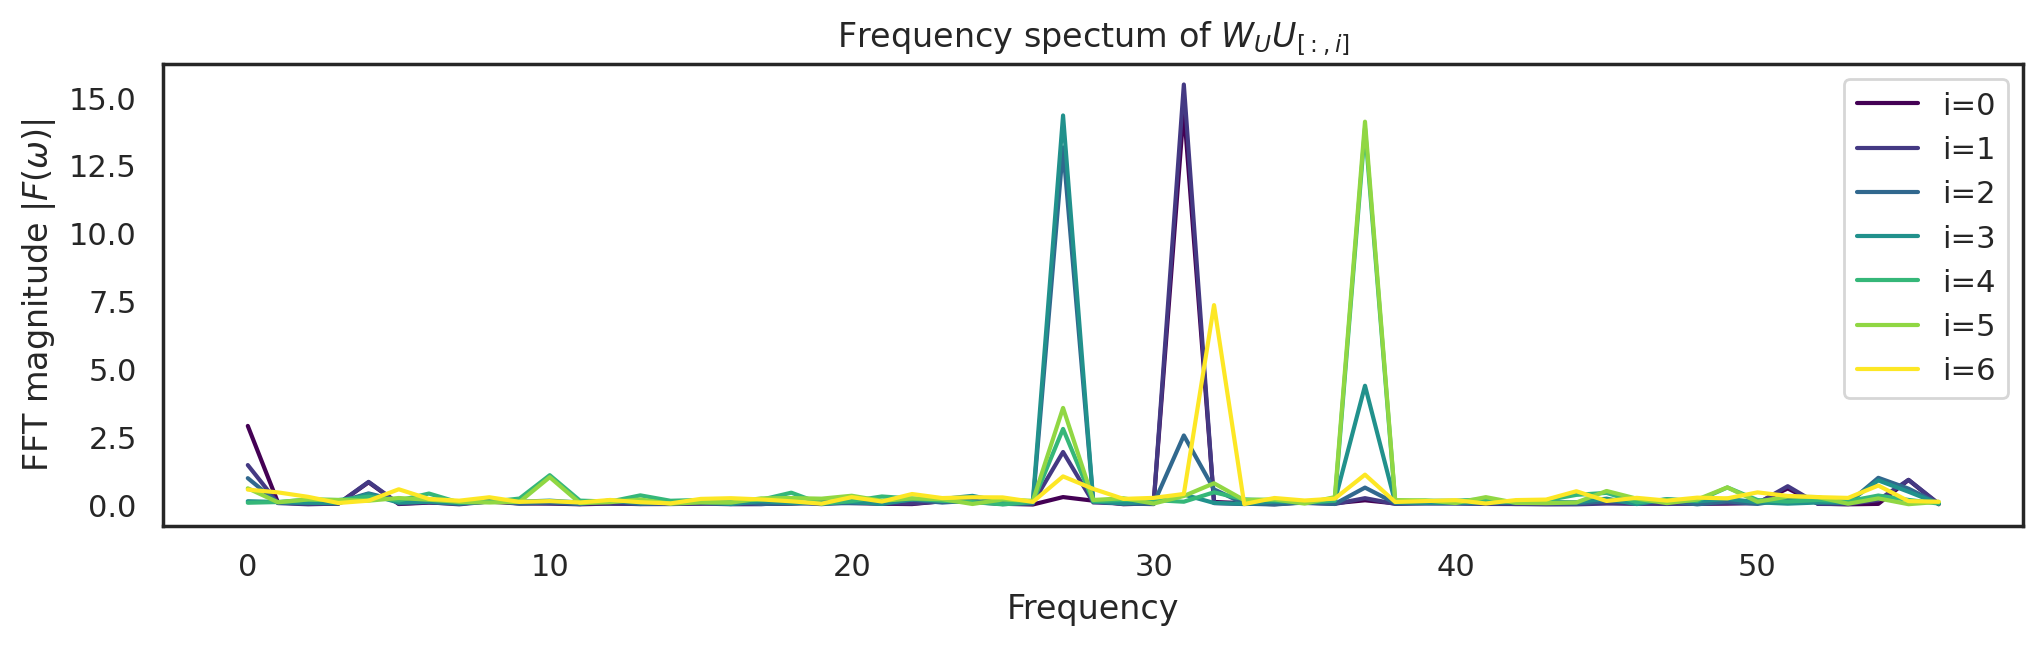

In [ ]:
u_largest = U[:,:7]
out_proj = W_U @ u_largest
out_proj_fft = t.fft.rfft(out_proj.T)
colors = [cm(x) for x in t.linspace(0,1,out_proj_fft.shape[0])]
plt.figure(figsize=(12,3), dpi=200)
for i, o_p_f in enumerate(out_proj_fft):
    plt.plot(o_p_f.abs().cpu(),color=colors[i], label=f"i={i}")
plt.legend()

plt.ylabel("FFT magnitude $|F(\\omega)|$")
plt.xlabel("Frequency")
_ = plt.title("Frequency spectum of $W_UU_{[:,i]}$")

Text(0, 0.5, 'Projection')

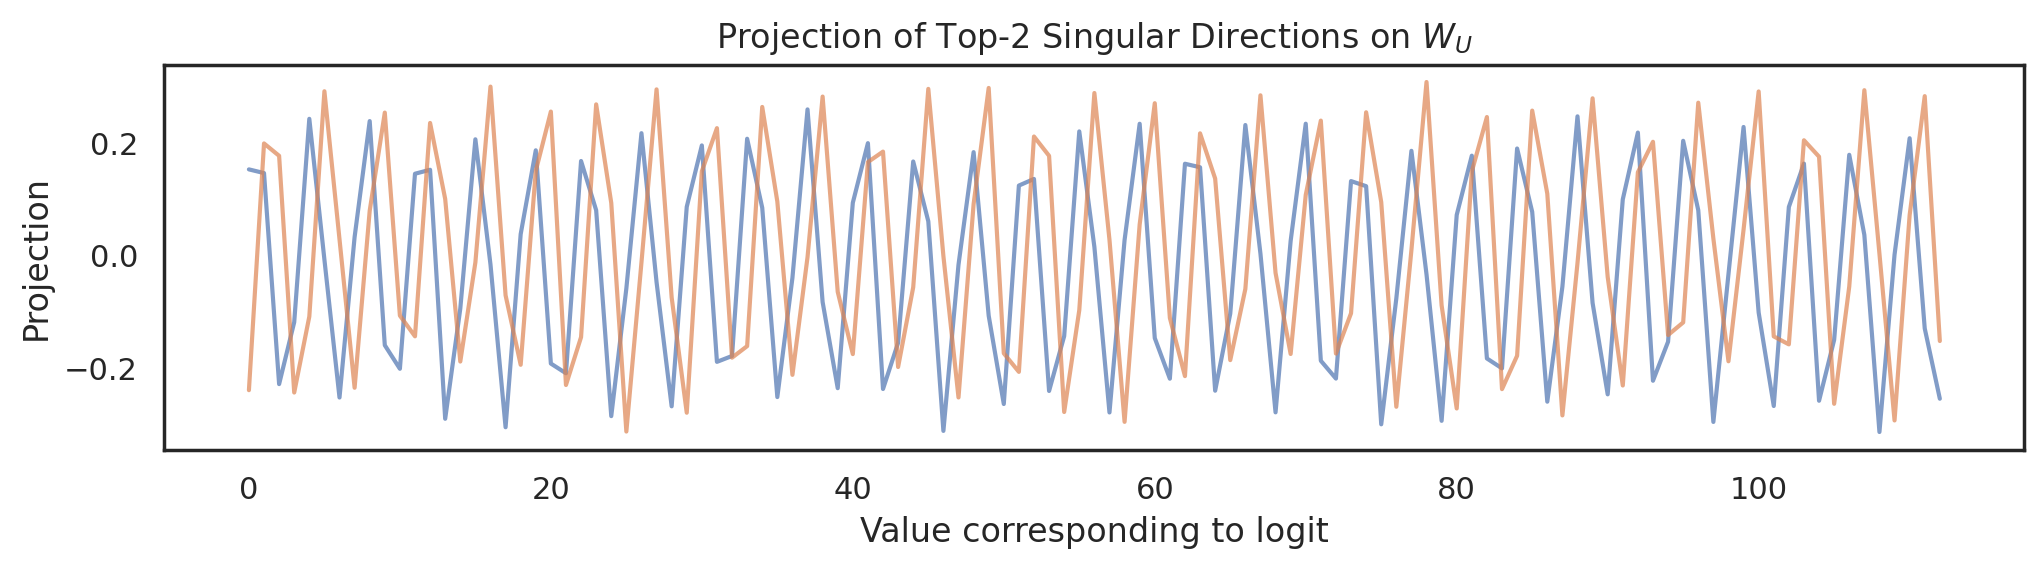

In [ ]:
u_largest = U[:,:2]
out_proj = W_U @ u_largest
plt.figure(figsize=(12,2.5), dpi=200)
plt.plot(out_proj.cpu(), alpha=0.7)
_ = plt.title("Projection of Top-2 Singular Directions on $W_U$")
plt.xlabel("Value corresponding to logit")
plt.ylabel("Projection")

Text(0.5, 0, '$j$')

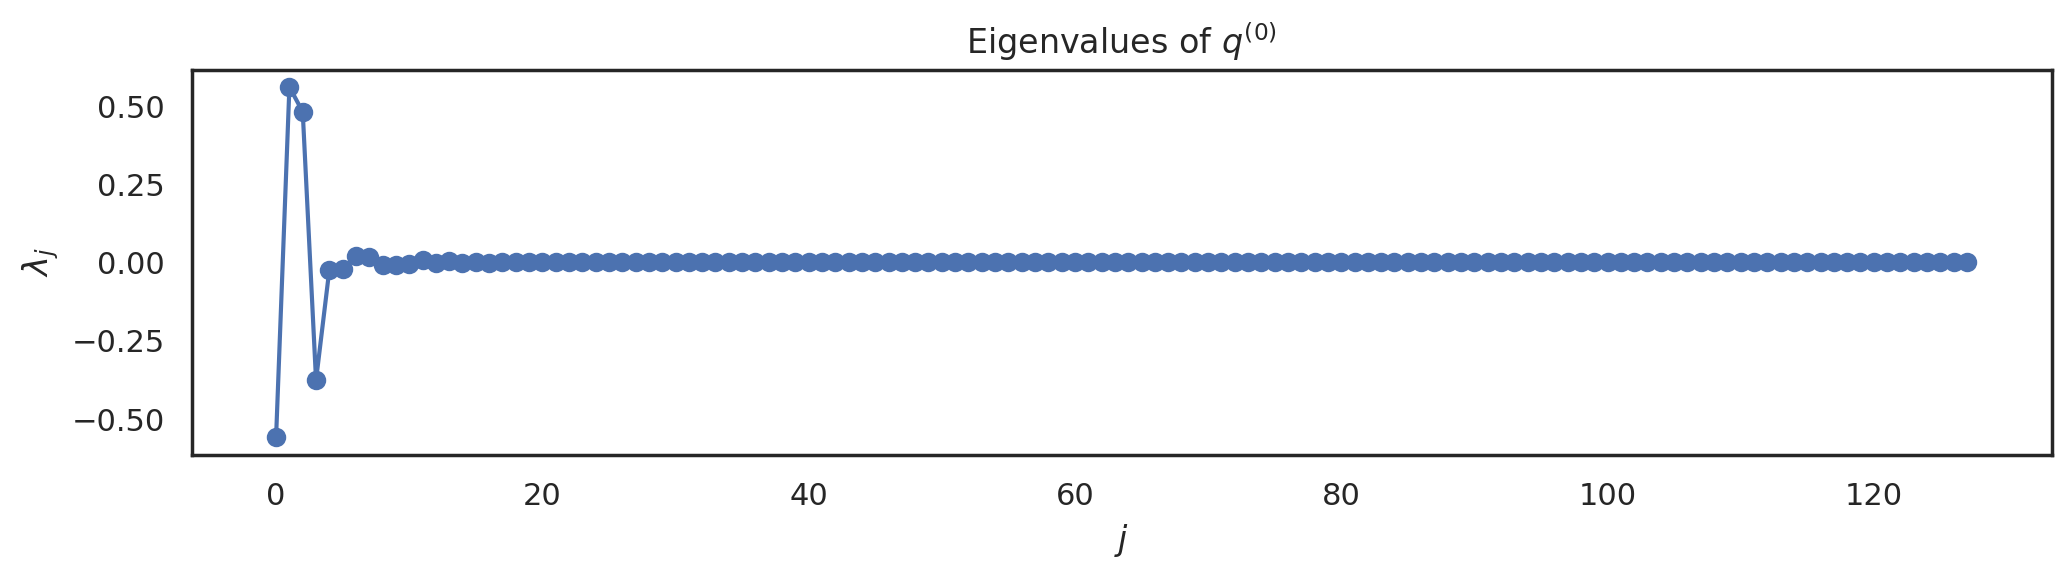

In [ ]:
i=0
eigvals, eigvect = t.linalg.eig(Q[i,:,:])

assert not t.any(eigvect.imag) and not t.any(eigvals.imag)

eigvals = eigvals.real
eigvect = eigvect.real
plt.figure(figsize=(12,2.5), dpi=200)
plt.plot(eigvals.cpu())
plt.scatter(range(d_model), eigvals.cpu())
plt.title("Eigenvalues of $q^{(0)}$")
plt.ylabel("$\\lambda_j$")
plt.xlabel("$j$")

In [ ]:
n_biggest = eigvect[:,:4]

X_y_pairs = [[m, 56, p, (m+1)%p] for m in range(p)]
X_y_tensor = t.tensor(X_y_pairs, dtype=t.long, device="cuda")

X = X_y_tensor[:,:-1]
y = X_y_tensor[:, -1]

In [ ]:
with model.trace(X) as trace:
    act = model.bl_mlp.input.save()
act = act[:,-1,:]

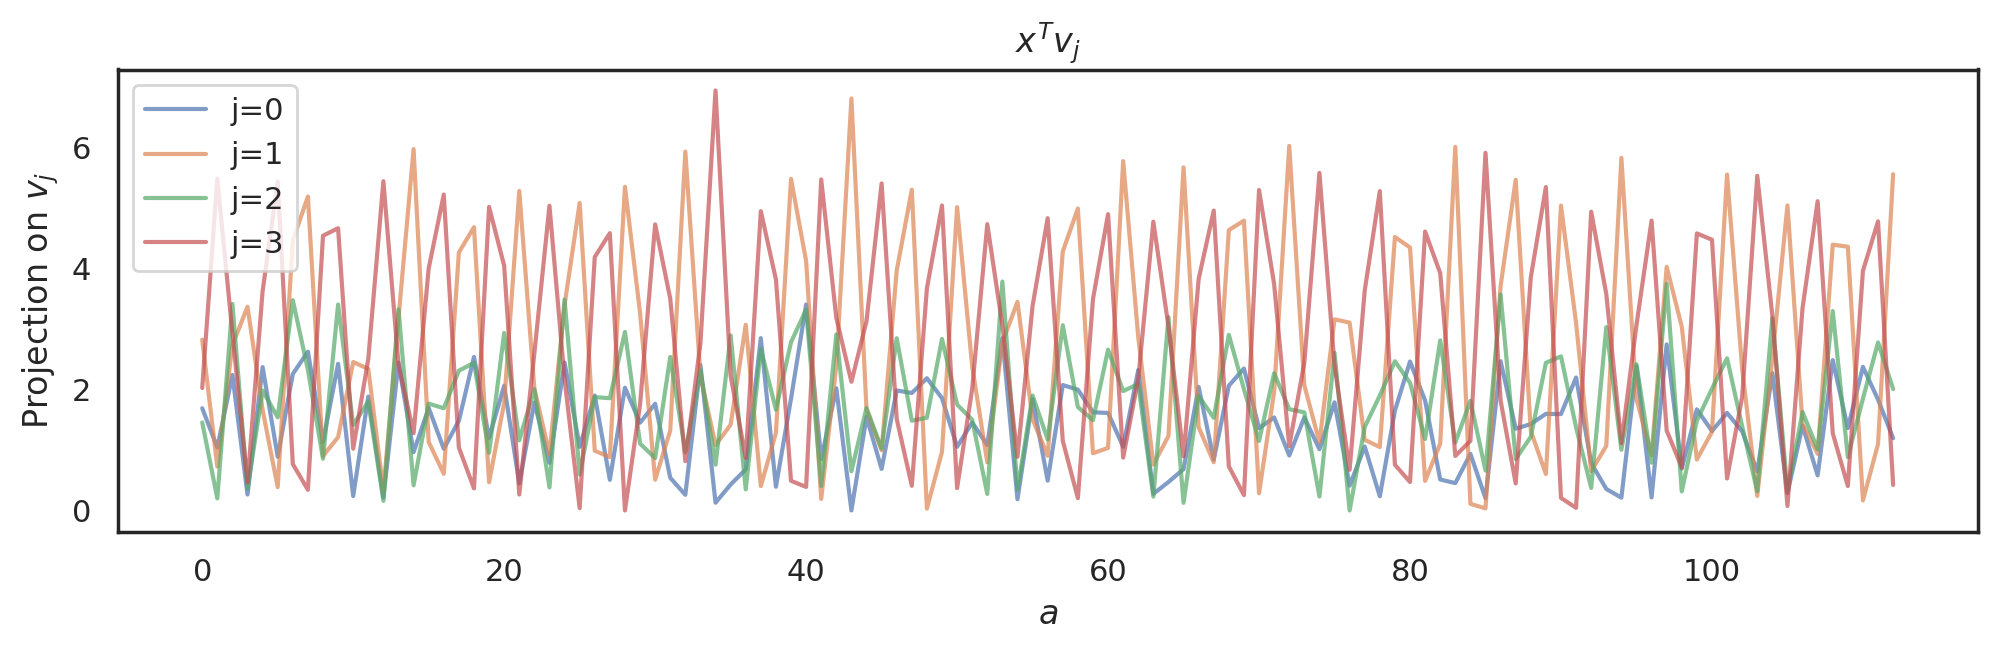

In [ ]:
plt.figure(figsize=(12,3), dpi=200)
proj = (act @ n_biggest)

plt.title("$x^Tv_j$")
plt.xlabel("$a$")
plt.ylabel("Projection on $v_j$")

for i, prj in enumerate(proj.T):
    plt.plot(prj.abs().cpu(), label=f"j={i}", alpha=0.7)
plt.legend()

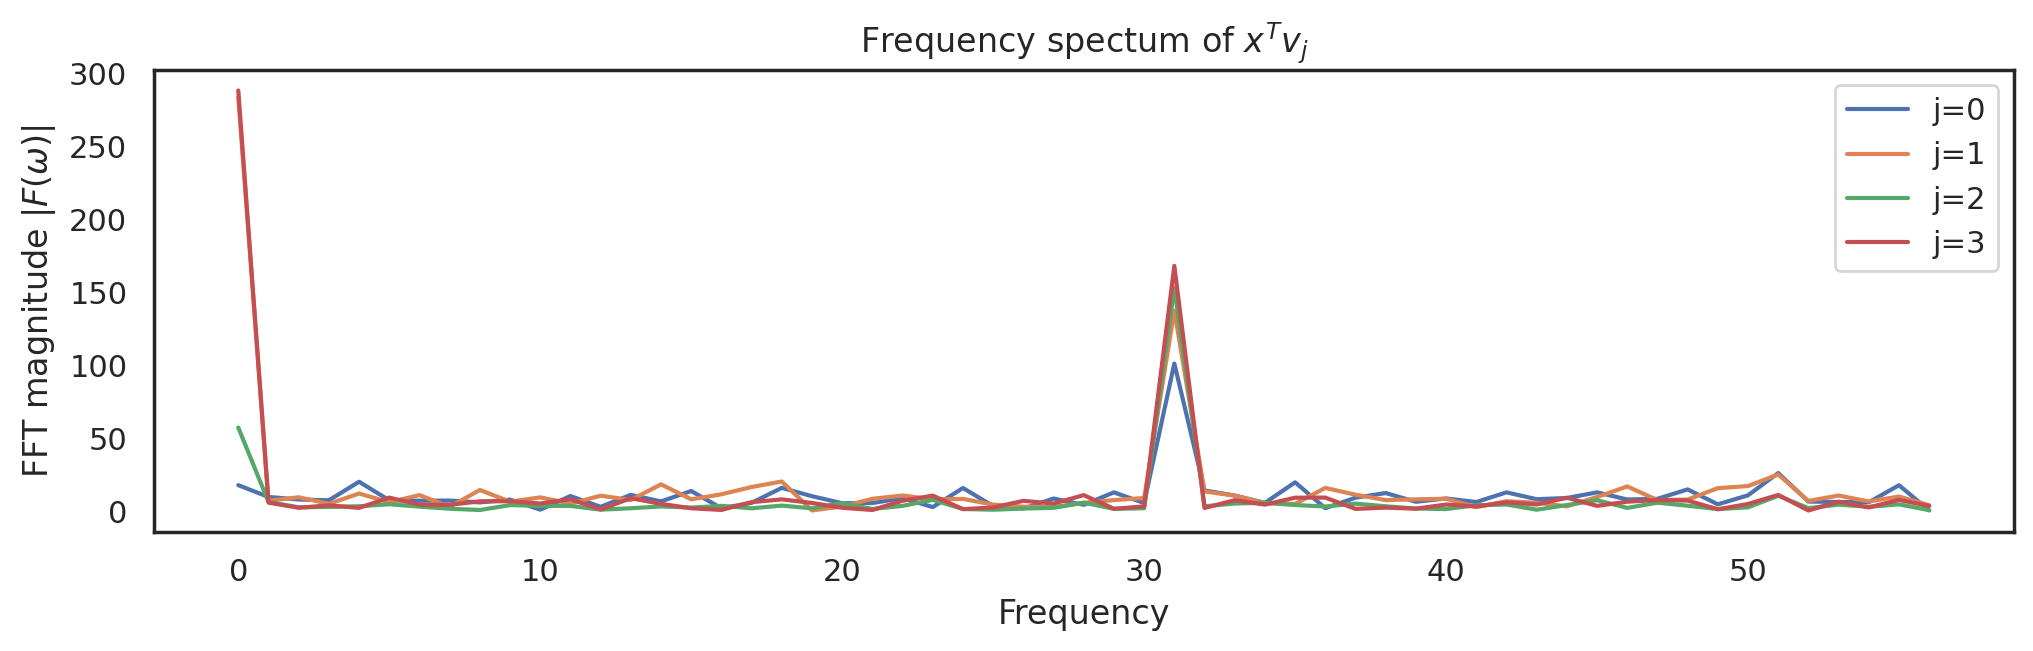

In [ ]:
in_proj_fft = t.fft.rfft(proj.T)
colors = [cm(x) for x in t.linspace(0,1,in_proj_fft.shape[0])]
plt.figure(figsize=(12,3), dpi=200)
for i, i_p_f in enumerate(in_proj_fft):
    plt.plot(i_p_f.abs().cpu(), label=f"j={i}")
plt.legend()

plt.ylabel("FFT magnitude $|F(\\omega)|$")
plt.xlabel("Frequency")
_ = plt.title("Frequency spectum of $x^Tv_j$")